In [ ]:
import rasterio
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
from rasterio.transform import rowcol
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

**Loading DEMs and flowline**

In [ ]:
in_directory= r"...\3.2_elevation_change\co_registered_dems\\**"
dem_list = glob.glob(os.path.join(in_directory, '*.tif'), recursive=True)

# Load the DEM (Assuming the DEM is in GeoTIFF format)
dem_file = dem_list[0]
with rasterio.open(dem_file) as dem_dataset:
    dem = dem_dataset.read(1)  # Read the DEM's first band (elevation)
    transform = dem_dataset.transform  # Affine transformation for pixel-to-world mapping

# Load the glacier center flowline (assuming shapefile or GeoJSON)
flowline_path = r"...\3.2_elevation_change\combined_flowline\flowline_both.shp"
flowline_gdf = gpd.read_file(flowline_path)
flowline = flowline_gdf.geometry[0]  # Assuming there's only one flowline (as a LineString)

**Define function to extract elevation values**

In [ ]:
def extract_elevation(dem, transform, flowline, interval=50, offset_distances=[50, 100, 150, 200]):
    """
    Extract DEM values along the flowline at regular intervals (in meters),
    and also sample points at specified distances (e.g., 100m, 200m) left and right from the flowline.
    Return the average of these elevations.
    
    Parameters:
    - dem: 2D array representing the DEM.
    - transform: affine transformation of the DEM.
    - flowline: LineString representing the glacier centerline.
    - interval: Distance (in meters) between each sample point along the flowline.
    - offset_distances: List of distances (in meters) to sample left and right of the flowline.
    
    Returns:
    - distances: List of distances along the flowline.
    - elevations: List of averaged elevation values (centerline, 100m left, 100m right, 200m left, 200m right).
    """
    # Generate points every `interval` meters along the flowline
    total_length = flowline.length
    distances = np.arange(0, total_length, interval)
    
    # Sample points at each distance interval along the flowline
    points_along_flowline = [flowline.interpolate(distance) for distance in distances]
    
    elevations = []
    for point in points_along_flowline:
        x, y = point.x, point.y  # Get x, y coordinates of the point
        
        # Get the tangent direction (derivative) of the flowline at this point
        point_ahead = flowline.interpolate(min(flowline.length, point.distance(flowline) + 1))
        direction_x = point_ahead.x - x
        direction_y = point_ahead.y - y
        
        # Normalize the direction to a unit vector and rotate to get left/right directions
        length = np.hypot(direction_x, direction_y)
        unit_vector_x = direction_x / length
        unit_vector_y = direction_y / length
        
        # Convert world coordinates (x, y) of centerline to DEM row, col
        row_center, col_center = rowcol(transform, x, y)
        
        # Store all elevation values (centerline, left, right)
        sampled_elevations = []
        
        # Sample centerline elevation first
        dem_height, dem_width = dem.shape
        if 0 <= row_center < dem_height and 0 <= col_center < dem_width:
            sampled_elevations.append(dem[row_center, col_center])
        
        # Loop over offset distances (e.g., 100m, 200m) for left and right sampling
        for offset in offset_distances:
            # Left offset: rotate unit vector by 90 degrees counter-clockwise
            left_x = -unit_vector_y * offset + x
            left_y = unit_vector_x * offset + y
            
            # Right offset: rotate unit vector by 90 degrees clockwise
            right_x = unit_vector_y * offset + x
            right_y = -unit_vector_x * offset + y
            
            # Convert world coordinates of left and right points to row, col in DEM
            row_left, col_left = rowcol(transform, left_x, left_y)
            row_right, col_right = rowcol(transform, right_x, right_y)
            
            # Sample elevation at the left point
            if 0 <= row_left < dem_height and 0 <= col_left < dem_width:
                sampled_elevations.append(dem[row_left, col_left])
            
            # Sample elevation at the right point
            if 0 <= row_right < dem_height and 0 <= col_right < dem_width:
                sampled_elevations.append(dem[row_right, col_right])
        
        # Calculate the average elevation from the centerline, left, and right samples
        if sampled_elevations:
            avg_elevation = np.median(sampled_elevations)
            elevations.append(avg_elevation)
    
    return distances, elevations


In [17]:
# Function to extract the full date (year_month_day) from the DEM filename
def extract_date_from_filename(dem_file):
    # Use a regular expression to extract the date (e.g., '2012_06_15' from 'aligned_2012_06_15.tif')
    match = re.search(r'(\d{4})_(\d{2})_(\d{2})', dem_file)
    if match:
        year, month, day = match.groups()
        return f'{year}_{month}_{day}'  # Return formatted date as 'year_month_day'
    else:
        name = dem_file.split('\\')[-1]
        name = name.split('.')[0]
        name = name.split('-')[0]
        return f'{name}'
    

In [18]:
# Function to process multiple DEMs and store the elevations in a DataFrame
def extract_elevations_multiple(dem_files, flowline, interval=50):
    data = {'distance': None}  # Dictionary to store the data
    distances = None

    # Loop over each DEM file
    for dem_file in dem_files:
        # Load each DEM
        with rasterio.open(dem_file) as dem_dataset:
            dem = dem_dataset.read(1)
            transform = dem_dataset.transform

            year = extract_date_from_filename(dem_file)
            dem_name = f'dem{year}'
            
            # Extract elevations from the current DEM
            distances, elevations = extract_elevation(dem, transform, flowline, interval=interval)
            
            # Store the results in the dictionary
            if data['distance'] is None:
                data['distance'] = distances  # Store distances only once
            data[dem_name] = elevations  # Store elevations under the DEM filename

    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame(data)
    return df

In [ ]:
df = extract_elevations_multiple(dem_list, flowline, interval=50)
df.replace(-9999.0, np.nan, inplace=True)


# remove values above water bodies anb replace them with the water body elevation
df.loc[df['distance'] > 12000, 'dem2023_09_30'] = 201
df.loc[df['distance'] < 1150, 'dem2023_09_30'] = 43
df.loc[df['distance'] > 15300, 'dem2012_08_14'] = 201
df.loc[df['distance'] < 1000, 'dem2012_08_14'] = 43
df.loc[df['distance'] < 200, 'demaligned_1987'] = 43
df.loc[df['distance'] > 15700, 'demaligned_1987'] = 201
df.loc[df['distance'] > 12200, 'dem2017_09_09'] = 201

df.loc[df['distance'] > 16000, df.columns != 'distance'] = np.nan

In [ ]:
df1 = df.copy()
df1['distance'] = df1['distance'].values[::-1]

**Plot elevation Profile**

C:\Users\florian\AppData\Local\Temp\ipykernel_23028\226767161.py:4: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05)


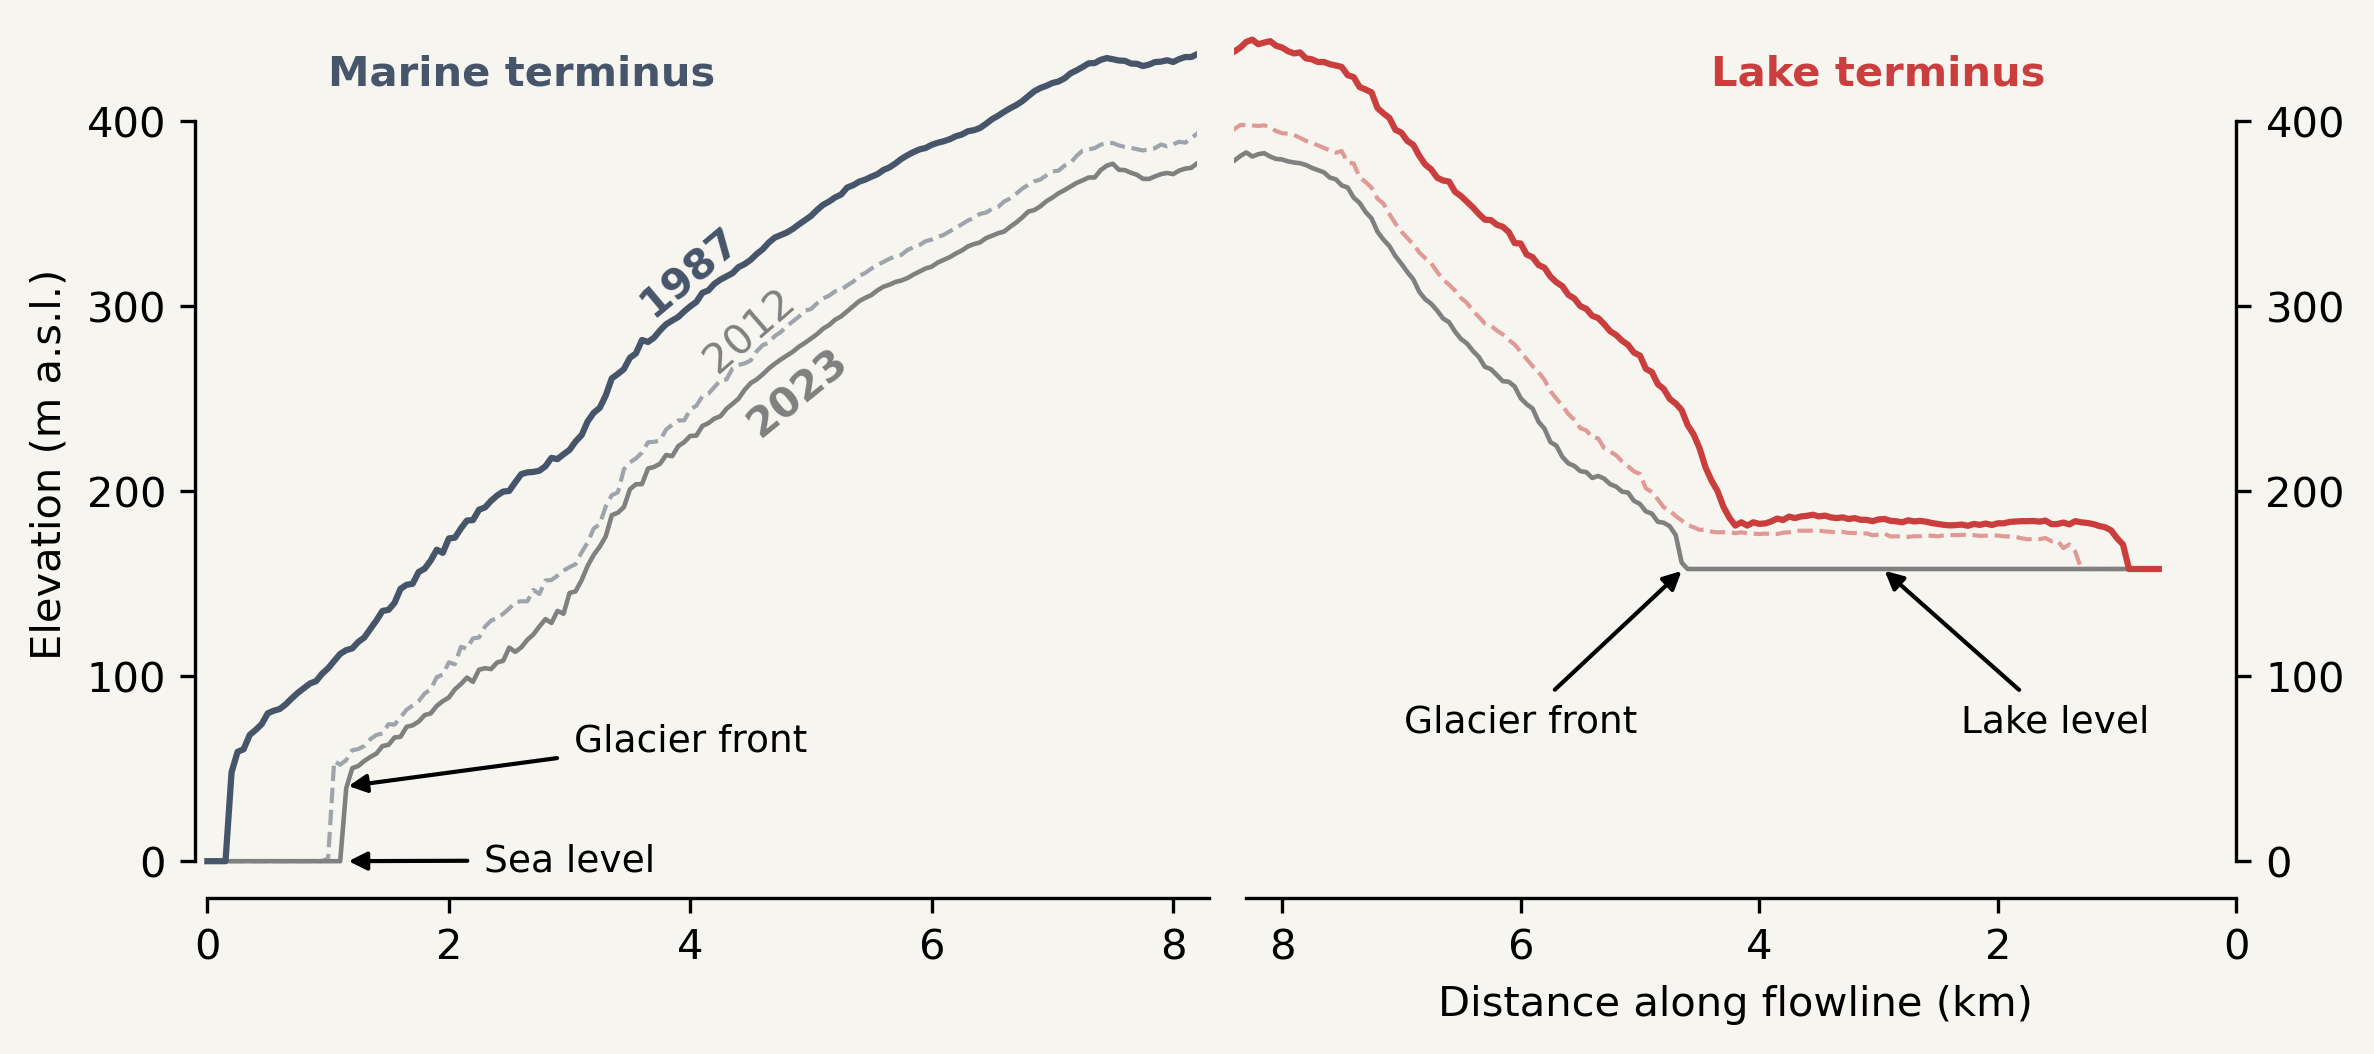

In [ ]:
# Create subplots, sharing the x-axis
fig, axs = plt.subplots(1, 2, figsize=(7.8, 3.4), dpi=300, facecolor='#f7f5efff', layout="constrained")#, layout="constrained"
(ax1, ax2) = axs
fig.subplots_adjust(wspace=0.05)

#colors and text
marinecolor = '#46556aff'
lakecolor = '#ca3e3dff'
ax1.set_facecolor('#f7f5efff')
ax2.set_facecolor('#f7f5efff')
fontsize = 10
ac ='black'

##############################################################################################################
# plotting ax1
ax1.plot(df.distance/1000, df.demaligned_1987 - 43, label="1987", color=marinecolor, zorder =1)
ax1.plot(df.distance/1000, df.dem2012_08_14 - 43, label="2012", color=marinecolor,zorder =0, alpha = 0.5, linestyle = '--', linewidth = 1)
ax1.plot(df.distance/1000, df.dem2023_09_30 - 43, label="2023", color='gray',zorder =0, linewidth = 1.1)
#ax1.fill_between(df.distance,-450,df.demBedMachineGreenland/2,color = '#e3e0cdff')

#axis formatting
ax1.spines[['top','right']].set_visible(False)
ax1.tick_params(right = False, labelright= False, labelsize = 10)
ax1.spines.left.set_bounds(0, 400)
ax1.spines.bottom.set_bounds(0, 8.3)
ax1.set_ylim(-20, 450)
ax1.set_xlim(-0.1, 8.2)

# text
ax1.set_ylabel('Elevation (m a.s.l.)')

ax1.annotate('Marine terminus', xy=(1, 420), fontsize = 10, ha='left', weight = 'bold', color = marinecolor)

ax1.annotate('Glacier front',
            (1.1, 40),
            xytext=(4, 60),
            ha='center', fontsize=9, arrowprops=dict(arrowstyle='-|>',color=ac), color = ac)

ax1.annotate('Sea level',
            (1.1, 0),
            xytext=(3, -5),
            ha='center', fontsize=9, arrowprops=dict(arrowstyle='-|>',color=ac), color = ac)

ax1.annotate('1987', xy=(4, 295), fontsize = 10, ha='center', rotation = 40, color = marinecolor, weight = 'bold')
ax1.annotate('2012', xy=(4.5, 265), fontsize = 10, ha='center', rotation = 41, color = 'gray')
ax1.annotate('2023', xy=(4.9, 230), fontsize = 10, ha='center', rotation = 39, color = 'gray', weight = 'bold')

##############################################################################################################
# plotting ax2
ax2.plot(df1.distance/1000, df1.demaligned_1987 - 43, label="1987", color=lakecolor, zorder =1)
ax2.plot(df1.distance/1000, df1.dem2012_08_14 - 43, label="2012", color=lakecolor,zorder =0, alpha = 0.5, linestyle = '--', linewidth = 1)
ax2.plot(df1.distance/1000, df1.dem2023_09_30 - 43, label="2023", color="gray",linewidth= 1.1, zorder = 0, alpha = 1)
#ax1.fill_between(df.distance,-450,df.demBedMachineGreenland/2,color = '#e3e0cdff')

#axis formatting
ax2.spines[['top', 'left']].set_visible(False)
ax2.tick_params(right = True, left= False, labelleft= False,  labelright= True, labelsize = 10)
ax2.spines.right.set_bounds(0, 400)
ax2.spines.bottom.set_bounds(0, 8.3)
ax2.set_ylim(-20, 450)
ax2.set_xlim(0, 8.4)
ax2.invert_xaxis()

#text
ax2.annotate('Lake terminus', xy=(3, 420), fontsize = 10, ha='center', weight = 'bold', color = lakecolor)#, color = lakecolor

ax2.annotate('Lake level',
            (3, 160),
            xytext=(1.52, 70),
            ha='center', fontsize=9, arrowprops=dict(arrowstyle='-|>',color=ac), color = ac)

ax2.annotate('Glacier front',
            (4.6, 160),
            xytext=(6, 70),
            ha='center', fontsize=9, arrowprops=dict(arrowstyle='-|>', color = ac), color = ac)

ax2.set_xlabel('Distance along flowline (km)')


#plt.savefig(r"path", dpi = 300)	
plt.show()
